# Multi-Label Classification

**Multi-label classification (movie can be labelled with multiple categories - romance and comedy)**

**$\neq$ Multi-class classification (E.g. binary classification => n-ary (multi-class) classification)**

**$\neq$ Multi-output classification (multiple types of outputs for a single observation / sample => predicting whether someone's probability of having cancer and probability of heart disease given body and diet features of the person)**

- multi-label you mean a classification problem whose response variable is discrete and it has a domain with cardinality > 2, i.e. not just {0,1} but for instance {A,B,C}

- multiple outputs you mean a supervised learning problem (hence, both regression and classification problems) whose response variable has a dimension >= 2, i.e. it's a vector and not a scalar 

We will go through how to train an NLP model for a multilabel classification task using the CMU Movie Summary Corpus. Firstly, let's setup an ETL pipeline to get the data, perform some EDA and data processing before we feed the finalized dataset into our multilabel models.

In [2]:
# Imports
import os
import csv
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))
            
# Create /data/ directory if it doesnt exist
mkdir('./data')

(./data) already exists


---
# ETL (Extract Transform Load) Pipeline

## Extract

We will download the entire MovieSummaries corpus, but we'll only want to keep the genres associated with the movie and also the plot summaries for our specific multi-genre labelling classification task.

### Download Data

In [2]:
# # URL for CMU Movie Summary Corpus
# url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'

# # Download dataset
# os.system('wget {}'.format(url))

In [3]:
# # Extract the tar.gz file into data directory
# # and delete tar.gz file
# os.system('tar -xzf MovieSummaries.tar.gz -C data && rm MovieSummaries.tar.gz')

### Get Movies and their Genres

In [4]:
# Get movies meta data
metadata = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', 
                       sep='\t',
                       header=None, 
                       index_col=0)

metadata.head()

,1,2,3,4,5,6,7,8
0,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
# Keep only name of movie, and genres
metadata_df = metadata.loc[:, [2, 8]]
metadata_df.loc[:, 8] = metadata_df[8].apply(lambda val: list(json.loads(val).values()))
metadata_df.columns = ['name', 'genres']
metadata_df.head()

,name,genres
0,,
975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,"[Crime Fiction, Drama]"
9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri..."
261236,A Woman in Flames,[Drama]


### Get Plots

In [6]:
# Plot summaries
plots = []

with open("./data/MovieSummaries/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:00, 51468.82it/s]


In [7]:
plots[0]

['23890098',
 "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."]

In [8]:
# Convert plots to a Dataframe
plots_df = pd.DataFrame.from_dict(dict(plots), orient='index', columns=['plot'])
plots_df.index = plots_df.index.astype('int64') 
plots_df.head()

,plot
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


### Merge Datasets

In [9]:
# Combine both datasets, and rename columns
df = pd.merge(metadata_df,
              plots_df,
              how='inner',
              left_index=True,
              right_index=True)

df.head()

,name,genres,plot
975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


## Transform

We will first perform a one-hot encoding of the `genres` column, and then do the standard nlp text processing procedures on the plot summary.

### One hot encode genres

In [10]:
# Get set of all possible genres
genre_set = set()

for genre_list in list(df['genres']):
    for item in genre_list:
        genre_set.add(item)
        
len(genre_set)

363

In [11]:
onehot_genres = df['genres'].apply(lambda genre_list: ','.join(['~'.join([genre, '1']) if genre in genre_list else '~'.join([genre, '0']) for genre in list(genre_set)])).str.split(pat=',', expand=True)

In [12]:
# Change column names for onehot_genres
onehot_genres.columns = onehot_genres.iloc[0, :].apply(lambda genre: genre.split('~')[0])

In [13]:
onehot_genres.head()

975900,New Hollywood,Anthropology,Children's,Musical comedy,Statutory rape,Mystery,Silent film,Instrumental Music,Fantasy Adventure,Gay Interest,...,Law & Crime,Plague,Spy,Sword and sorcery,Experimental film,Extreme Sports,Acid western,Goat gland,Expressionism,Mondo film
975900,New Hollywood~0,Anthropology~0,Children's~0,Musical comedy~0,Statutory rape~0,Mystery~0,Silent film~0,Instrumental Music~0,Fantasy Adventure~0,Gay Interest~0,...,Law & Crime~0,Plague~0,Spy~0,Sword and sorcery~0,Experimental film~0,Extreme Sports~0,Acid western~0,Goat gland~0,Expressionism~0,Mondo film~0
9363483,New Hollywood~0,Anthropology~0,Children's~0,Musical comedy~0,Statutory rape~0,Mystery~0,Silent film~0,Instrumental Music~0,Fantasy Adventure~0,Gay Interest~0,...,Law & Crime~0,Plague~0,Spy~0,Sword and sorcery~0,Experimental film~0,Extreme Sports~0,Acid western~0,Goat gland~0,Expressionism~0,Mondo film~0
261236,New Hollywood~0,Anthropology~0,Children's~0,Musical comedy~0,Statutory rape~0,Mystery~0,Silent film~0,Instrumental Music~0,Fantasy Adventure~0,Gay Interest~0,...,Law & Crime~0,Plague~0,Spy~0,Sword and sorcery~0,Experimental film~0,Extreme Sports~0,Acid western~0,Goat gland~0,Expressionism~0,Mondo film~0
18998739,New Hollywood~0,Anthropology~0,Children's~0,Musical comedy~0,Statutory rape~0,Mystery~0,Silent film~0,Instrumental Music~0,Fantasy Adventure~0,Gay Interest~0,...,Law & Crime~0,Plague~0,Spy~0,Sword and sorcery~0,Experimental film~0,Extreme Sports~0,Acid western~0,Goat gland~0,Expressionism~0,Mondo film~0
6631279,New Hollywood~0,Anthropology~0,Children's~0,Musical comedy~0,Statutory rape~0,Mystery~0,Silent film~0,Instrumental Music~0,Fantasy Adventure~0,Gay Interest~0,...,Law & Crime~0,Plague~0,Spy~0,Sword and sorcery~0,Experimental film~0,Extreme Sports~0,Acid western~0,Goat gland~0,Expressionism~0,Mondo film~0


In [14]:
onehot_genres = onehot_genres.apply(func=lambda row: [int(cell.split('~')[1]) for cell in row])
onehot_genres.head()

975900,New Hollywood,Anthropology,Children's,Musical comedy,Statutory rape,Mystery,Silent film,Instrumental Music,Fantasy Adventure,Gay Interest,...,Law & Crime,Plague,Spy,Sword and sorcery,Experimental film,Extreme Sports,Acid western,Goat gland,Expressionism,Mondo film
975900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9363483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18998739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6631279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Drop genres
df.drop(['genres'], axis=1, inplace=True)

In [16]:
# Merge it back with df
final_df = pd.merge(df, 
                    onehot_genres,
                    how='inner',
                    left_index=True,
                    right_index=True)
final_df.head()

,name,plot,New Hollywood,Anthropology,Children's,Musical comedy,Statutory rape,Mystery,Silent film,Instrumental Music,...,Law & Crime,Plague,Spy,Sword and sorcery,Experimental film,Extreme Sports,Acid western,Goat gland,Expressionism,Mondo film
975900,Ghosts of Mars,"Set in the second half of the 22nd century, th...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9363483,White Of The Eye,A series of murders of rich young women throug...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261236,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18998739,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6631279,Little city,"Adam, a San Francisco-based artist who works a...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Standard NLP text processing for the plot summaries

In [17]:
def tokenize(text: str):
    """
    Function: 
    ---------
    Processes the text string into word tokens for an NLP model,
    with stop words removed, lemmatized, and everything is lowercase
    
    Parameters:
    -----------
    text: A str type, the sentence you want to tokenize
    
    Returns:
    --------
    A list of word tokens
    """
    return [WordNetLemmatizer().lemmatize(token.strip(), pos='v') for token in word_tokenize(text.lower()) if token not in stopwords.words("english") and token not in list(string.punctuation)]

## Load

In [ ]:
engine = create_engine('sqlite:///DisasterResponse.db')
df.to_sql('DisasterResponse', engine, index=False)

## Exploratory Data Analysis

In [18]:
# Let's take a look at the breakdown of the 
# number of movies in each of the top 50 genres
genre_count = pd.DataFrame(cleaned_df.drop(['name', 'plot'], axis=1).apply(lambda col: np.sum(col), axis=0)).reset_index()
genre_count.columns = ['genre', 'count']

plt.figure(figsize=(8, 12), dpi=300)
sns.barplot(data=genre_count.sort_values(by='count', ascending=False)[:50], 
            x='count', y='genre')
plt.grid();

NameError: name 'cleaned_df' is not defined

Our data is imbalanced and we should combat this using imbalanced data techniques

---
# Evaluation Metrics

1. Micro Averaging
2. Macro Averaging
3. Hamming-Loss
4. Exact Match Ratio

## Micro Averaging

All TPs, TNs, FPs and FNs for each class are summed up and then the average is taken. Using these averaged TPs, TNs, FPs and FNs, we calculate the precision, recall, and subsequently F1 score and ROC-AUC.

## Macro Averaging

Precision, recall, F1-score, and ROC-AUC are calculated for each class and averaged.

---
## Hamming-Loss



---
## Exact Match Ratio

---
# Multi-Label Classification Techniques

Two Techniques:
1. Problem Transformation: Multi-label problem is transformed into one or more singlelabel problems. In this fashion, a single-label classifier can be employed to make single-label classifications, and these are then transformed back into multi-label representations
    - OneVsRest / OneVsOne
    - Binary Relevance
        - **Assumes Label Independence**
        - Simple and Intuitive
        - Low Computational Complexity
        - Transforms any multi-label problem into one binary problem for each label
        - Hence this method trains |L| binary classifiers $C_1,\ldots, C_{\vert L\vert}$. Each classifier $C_j$ is responsible for predicting the 0/1 association for each corresponding label $l_j \in L$
        - Ignores label correlations that exist in the training data.
        - Due to this information loss, Binary Relevance method’s predicted label sets are likely to contain either too many or too few labels, or labels that would never co-occur in practice.
            - E.g. if we have the labels `dr` and `flood`, but there are words in the text that hint at both the labels, binary classification for each label might end up giving us `True` for both `dry` and `flood` which is highly unlikely.
    - Classifier Chains
        - The classification process begins at Binary Classifier $C_1$ and propagates along the chain: $C_1$ determines $P(l_1\mid x)$ and every following classifier $C_2, \ldots, C_{\vert L \vert}$ predicts $P(l_j \mid x_i, l_1, \ldots, l_{j−1})$.
        - Ensemble Classifier Chains (ECC)
            - ECC trains $m$ CC classifiers $C_1, C_2, \ldots, C_m$. Each $C_k$ is trained with:
                - a random chain ordering (of $L$)
                - a random subset of $D$
            - Hence each $C_k$ model is likely to be unique and able to give different multilabel predictions. These predictions are summed by label so that each label receives a number of votes. A threshold is used to select the most popular labels which form the final predicted multi-label set.
    - Label Combination / Powerset
        - Upper bound complexity of $min(\vert D \vert, 2^{\vert L \vert})$
        - Combine entire label sets into atomic (single) labels to form a single-label problem for which the set of possible single labels represents all distinct label subsets in the original multi-label representation
        - Each $(x, S)$ is transformed into $(x, l)$ where $l$ is the atomic label representing a distinct label subset. In this way, CM-based methods directly take into account label correlations. A disadvantage of these methods, however, is their worst-case time complexity.
2. Algorithm Adaptation
    - Multi-label k-Nearest Neighbours (ML-KNN)
    - Multi-label Decision Trees / Adaboost

---
# OneVsRest

---
# Classifier Chains

- Accounts for label dependencies, e.g. movie category predictions for romance will have a higher probability to get the label comedy too rather than horror.

Automatically created module for IPython interactive environment


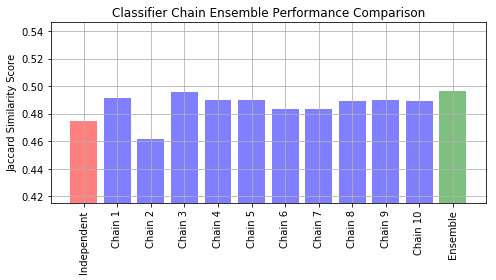

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression

print(__doc__)

# Load a multi-label dataset from https://www.openml.org/d/40597
X, Y = fetch_openml('yeast', version=4, return_X_y=True)
Y = Y == 'TRUE'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,
                                                    random_state=0)

# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression(solver='lbfgs')
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average='samples')

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_score(Y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test,
                                       Y_pred_ensemble >= .5,
                                       average='samples')

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

---
## Resources:

- [Journey to the center of multi-label classification](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)
- [Predicting Movie Genres using NLP – An Awesome Introduction to Multi-Label Classification](https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/)
- [sklearn Classifier chain example](https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html#sphx-glr-auto-examples-multioutput-plot-classifier-chain-yeast-py)
- [Classifier chain wiki](https://en.wikipedia.org/wiki/Classifier_chains)
- [Classifier chains for Multi-label Classification](https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf)
- [Building a Multi-label Text Classifier using BERT and TensorFlow](https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d)